<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/centralized_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
!pip install --upgrade torch

## Imports

In [109]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Costants

In [110]:
NUM_EPOCHS = 2
BATCH_SIZE = 64
LR = 0.01         # Choose 'SGDM': "lr": 0.01, "weight_decay": 0.001, "momentum": 0.9,
WD = 0.001         # Choose 'AdamW': "lr": 0.001, "weight_decay": 0.1,
MOMENTUM = 0.9
EPS = 0.0001
OPTIMIZER = 'SGDM'  # Choose from: 'SGDM', 'AdamW'
try:
    with open('/content/drive/MyDrive/best_hyperparams_SGDM.json', 'r') as f:    #best_hyperparams_AdamW.json or best_hyperparams_SGDM.json
        best_hyperparams = json.load(f)
except FileNotFoundError:
    best_hyperparams = {
        'lr': LR,
        'weight_decay': WD,
        'momentum': MOMENTUM,
        'eps': EPS,
        'patience': 150
    }

## Model

In [111]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Function to get train, test and val dataset

In [112]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=2)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [113]:
def get_dataset(batch_size, verbose=True):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )
    print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Debugging: Check DataLoader outputs
    for i, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
        if i == 10:  # Test first 10 batches
            break
    print(f"Data loading for 10 batches completed.")

    return train_dataset, train_loader, val_loader, test_loader

In [114]:
class CheckpointSaver:

  def __init__(self, path, OPTIMIZER, best_hyperparams, epochs):
    self.timestamp = time.strftime("%Y%m%d-%H%M%S")
    self.path = f"{path}/Centralized_{OPTIMIZER}_{self.timestamp}"
    self.best_hyperparams = best_hyperparams
    self.epochs = epochs

  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'train_acc': os.path.join(self.path, f'{OPTIMIZER}_train_accuracy_{self.timestamp}.txt'),
        'val_acc': os.path.join(self.path, f'{OPTIMIZER}_val_accuracy_{self.timestamp}.txt'),
        'train_loss': os.path.join(self.path, f'{OPTIMIZER}_train_loss_{self.timestamp}.txt'),
        'val_loss': os.path.join(self.path, f'{OPTIMIZER}_val_loss_{self.timestamp}.txt')
    }

    with open(os.path.join(self.path, f'{OPTIMIZER}_experiment_config_{self.timestamp}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"Optimizer: {OPTIMIZER}\n")
        f.write(f"Hyperparameters: {str(self.best_hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")
        f.write(f"Timestamp: {self.timestamp}\n")


  def save_checkpoint(self, epoch, train_acc, val_acc, train_loss, val_loss):
      try:
          with open(self.metrics_files['train_acc'], 'a') as f:
              f.write(f"{epoch+1},{train_acc * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch+1},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['train_loss'], 'a') as f:
              f.write(f"{epoch+1},{train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch+1},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")



## Centralized baseline training function

In [115]:
def train_model_with_hyperparams(train_loader, val_loader, test_loader, best_hyperparams, num_epochs, device, type_of_optimizer):
    model = LeNet5().to(device)

    if type_of_optimizer == "SGDM":
        if best_hyperparams.get('momentum', None) is None:
            raise ValueError("Momentum is required for SGDM")
        if best_hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for SGDM")
        if best_hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for SGDM")

        optimizer = optim.SGD(
            model.parameters(),
            lr=best_hyperparams['lr'],
            weight_decay=best_hyperparams['weight_decay'],
            momentum=best_hyperparams['momentum'],
        )

    elif type_of_optimizer == "AdamW":
        if best_hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for AdamW")
        if best_hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for AdamW")

        optimizer = optim.AdamW(
            model.parameters(),
            lr=best_hyperparams['lr'],
            weight_decay=best_hyperparams['weight_decay'],
            eps=best_hyperparams.get('eps', 1e-8)
        )
    else:
        raise ValueError("Invalid optimizer type")

    print(f"Train running with {type_of_optimizer} optimizer.")

    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    cs = CheckpointSaver(
        path=f"/content/drive/My Drive/Colab Notebooks/Traning_summary/",
        OPTIMIZER=OPTIMIZER,
        best_hyperparams=best_hyperparams,
        epochs=num_epochs
    )

    cs.create_files()


    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_model = None
    best_val_loss = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        cs.save_checkpoint(epoch, train_acc, val_acc, train_loss, val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())

        scheduler.step()




    # Test loop
    if best_model is not None:
        model.load_state_dict(best_model)
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, cs.path


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/training_results.png")
    print(f"Training results saved to {save_path}")
    plt.show()

## Main

Start loading data with batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 3.04 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torc

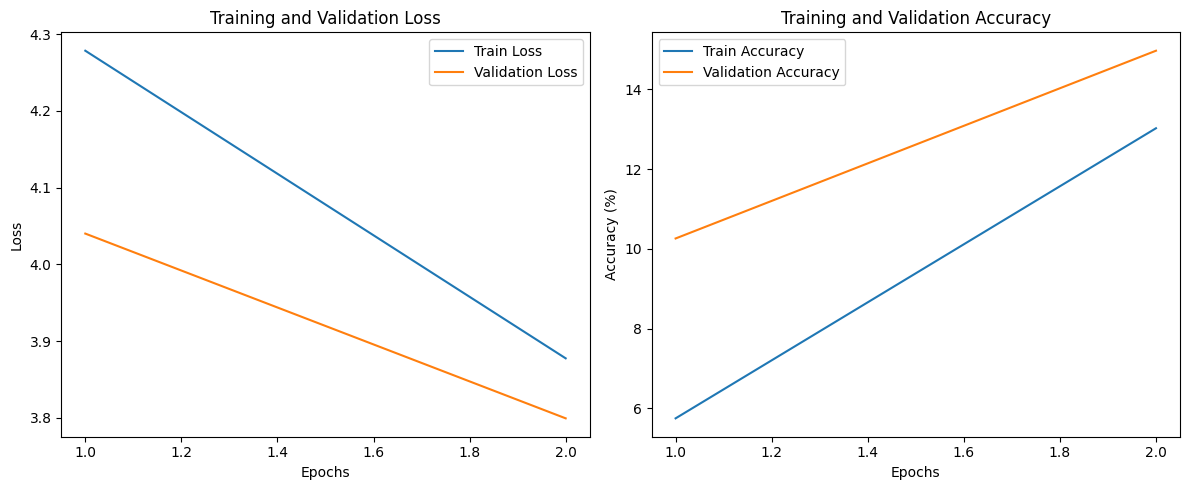

In [116]:
if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset, train_loader, val_loader, test_loader = get_dataset(BATCH_SIZE)

    print("\nUsing Best Hyperparameters from Grid Search:", best_hyperparams)

    # Train with the best hyperparameters
    train_losses, val_losses, train_accuracies, val_accuracies, test_acc, save_path = train_model_with_hyperparams(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        best_hyperparams=best_hyperparams,
        num_epochs=NUM_EPOCHS,
        device=device,
        type_of_optimizer=OPTIMIZER
    )
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies, save_path)
